# Resize and Add Padding to the Images
This is so they all have the same size of 800 x 600

In [2]:
from PIL import Image, ImageOps
import os

In [2]:
def resize_and_pad_images(input_folder, output_folder, target_size=(800, 600), background_color=(255, 255, 255)):
    """
    Resize images and place them on a plain background of the specified size.

    Parameters:
        input_folder (str): Path to the folder containing input images.
        output_folder (str): Path to the folder to save output images.
        target_size (tuple): Target size (width, height) for the output images.
        background_color (tuple): Background color as an RGB tuple.
    """
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('png', 'jpg', 'jpeg')):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            # Open the image
            with Image.open(input_path) as img:
                # Resize image to fit within the target size while maintaining aspect ratio
                img.thumbnail((target_size[0], target_size[1]))

                # Create a new image with the target size and background color
                background = Image.new('RGB', target_size, background_color)

                # Calculate position to center the image on the background
                x_offset = (target_size[0] - img.width) // 2
                y_offset = (target_size[1] - img.height) // 2

                # Paste the resized image onto the background
                background.paste(img, (x_offset, y_offset))

                # Save the output image
                background.save(output_path)

    print(f"Processed images are saved in: {output_folder}")

In [3]:
def resize_and_pad_images(input_folder, output_folder, target_size=(800, 600), background_color=(255, 255, 255)):
    """
    Stretch the image to fill either width or height, then add padding to make the image fit the target size (800x600).

    Parameters:
        input_folder (str): Path to the folder containing input images.
        output_folder (str): Path to the folder to save output images.
        target_size (tuple): Target size (width, height) for the output images.
        background_color (tuple): Background color as an RGB tuple.
    """
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            # Open the image
            with Image.open(input_path) as img:
                img_width, img_height = img.size

                # Calculate the target size while stretching the image
                if img_width > img_height:
                    # Stretch the image to match the target width (800)
                    new_width = target_size[0]
                    new_height = int((img_height / img_width) * target_size[0])
                else:
                    # Stretch the image to match the target height (600)
                    new_height = target_size[1]
                    new_width = int((img_width / img_height) * target_size[1])

                # Resize the image to stretched dimensions
                img = img.resize((new_width, new_height), Image.ANTIALIAS)

                # Create a new image with the target size and background color
                background = Image.new('RGB', target_size, background_color)

                # Calculate the position to center the image on the background
                x_offset = (target_size[0] - new_width) // 2
                y_offset = (target_size[1] - new_height) // 2

                # Paste the resized image onto the background
                background.paste(img, (x_offset, y_offset))

                # Save the output image
                background.save(output_path)

    print(f"Processed images are saved in: {output_folder}")

In [4]:
# Replace the path with folders
input_folder = "./Data/train" # Replace with the path to your input folder
output_folder = "./Data/resized_images/resized_train"  # Replace with the path to your output folder
resize_and_pad_images(input_folder, output_folder)

C:\Users\edely\AppData\Local\Temp\ipykernel_19604\1890557508.py:34: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((new_width, new_height), Image.ANTIALIAS)


Processed images are saved in: ./Data/resized_images/resized_train


# Extract the Landmarks from the Photos

For the landmarks, put them in a folder called "mediapipe_images", and the numbers in a CSV file called "cleaned_data"

In [ ]:
import cv2
import mediapipe as mp
import os
from tqdm import tqdm
import pandas as pd

In [ ]:
def extract_and_overlay_pose_landmarks(frames_dir, output_csv, output_images_dir):
    """
    Extract pose landmarks, overlay them on images, and handle incomplete detections.

    Args:
        frames_dir (str): Directory containing input images.
        output_csv (str): Path to the output CSV file for landmarks.
        output_images_dir (str): Directory to save images with landmarks overlayed.

    """
    # Initialize MediaPipe Pose
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=True, model_complexity=2)
    mp_drawing = mp.solutions.drawing_utils

    # Get landmark names
    landmark_names = [landmark.name for landmark in mp_pose.PoseLandmark]

    # Prepare the output CSV column names
    columns = ["frame"] + [f"{name}_{axis}" for name in landmark_names for axis in ["x", "y", "z", "visibility"]]
    data = []

    # Create output directory if it doesn't exist
    if not os.path.exists(output_images_dir):
        os.makedirs(output_images_dir)

    # Track problematic frames
    problematic_frames = []

    # Process each frame
    frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith(('.jpg', '.png', '.JPG'))])
    for frame_file in tqdm(frame_files, desc="Processing frames"):
        frame_path = os.path.join(frames_dir, frame_file)
        image = cv2.imread(frame_path)
        if image is None:
            print(f"Warning: Unable to read image {frame_file}. Skipping...")
            problematic_frames.append(frame_file)
            continue

        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        # Extract landmarks
        if results.pose_landmarks:
            landmarks = []
            for lm in results.pose_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z, lm.visibility])

            # Check if all landmarks are detected (non-zero visibility)
            all_visible = all(lm.visibility > 0 for lm in results.pose_landmarks.landmark)

            if not all_visible:
                print(f"Incomplete detection in {frame_file}. Skipping...")
                problematic_frames.append(frame_file)
                continue

            # Save landmarks data
            data.append([frame_file] + landmarks)

            # Draw landmarks on the image
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Save the processed image with landmarks overlayed
            output_image_path = os.path.join(output_images_dir, frame_file)
            cv2.imwrite(output_image_path, image)

        else:
            print(f"No landmarks detected in {frame_file}. Skipping...")
            problematic_frames.append(frame_file)

    # Save landmarks to CSV
    if data:
        df = pd.DataFrame(data, columns=columns)
        df.to_csv(output_csv, index=False)
        print(f"Landmarks saved to {output_csv}")
    else:
        print("No valid landmarks were detected.")

    # Print problematic frames
    if problematic_frames:
        print("Frames with issues:")
        for frame in problematic_frames:
            print(f" - {frame}")

        # Optionally, delete problematic frames from the output directory
        for frame in problematic_frames:
            output_image_path = os.path.join(output_images_dir, frame)
            if os.path.exists(output_image_path):
                os.remove(output_image_path)

    print(f"Processed images saved to {output_images_dir}")

In [ ]:
if __name__ == "__main__":
    # Path to frames directory
    frames_dir = "./Data/resized_images/resized_train"
    # Path to output CSV file
    output_csv = "./Cleaned Data/Pushup CSV/correct_pose_landmarks.csv"
    # Path to output directory for processed images
    output_images_dir = "./Processed Images/Pushup Frames/Correct Frames"

    # Extract pose landmarks and overlay them on images
    extract_and_overlay_pose_landmarks(frames_dir, output_csv, output_images_dir)

# Combine Correct CSV and Wrong CSV

After extracting both correct and wrong frames, combine them into one CSV file

In [1]:
import pandas as pd

In [2]:
# Define the landmarks to exclude
excluded_landmarks = [
    "NOSE", "LEFT_EYE_INNER", "LEFT_EYE", "LEFT_EYE_OUTER",
    "RIGHT_EYE_INNER", "RIGHT_EYE", "RIGHT_EYE_OUTER",
    "LEFT_EAR", "RIGHT_EAR", "MOUTH_LEFT", "MOUTH_RIGHT"
]

In [17]:
# Load both CSV files, change to what's going to be combined
squat_df = pd.read_csv('./Data/cleaned_data/separate/train_landmarks.csv')
annotations_df = pd.read_csv('./Data/train/_annotations.csv')

annotations_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,quats-exercising-gym-with-barbell-white-wall-i...,626,417,Good_Squat,222,23,518,399
1,images388_jpg.rf.048904374288cc84f94c13a94781f...,300,168,Shallow_Squat,102,51,211,160
2,images527_jpg.rf.081f471c5dc53b1aa11176b3e5b62...,275,183,Shallow_Squat,91,29,197,171
3,images457_jpg.rf.03f606941595cd4edac0a472f03ed...,183,275,Good_Squat,20,68,145,266
4,ing-resistance-bands-full-body-isolated-white-...,1068,1689,Good_Squat,78,522,1012,1506
...,...,...,...,...,...,...,...,...
182,maxresdefault_jpg.rf.ffc1cf9f4338aa6756835e5f6...,1280,720,Good_Squat,557,290,771,647
183,images480_jpg.rf.fe25249fcced2b8fb383d448ab75e...,300,168,Shallow_Squat,122,50,169,158
184,youtube-14_jpg.rf.faa40c6708ad7eb8a778a1e07c7c...,1920,1080,Good_Squat,245,202,444,540
185,youtube-14_jpg.rf.faa40c6708ad7eb8a778a1e07c7c...,1920,1080,Good_Squat,627,158,1093,1078


In [9]:
# Filter out columns related to excluded landmarks
def filter_landmarks(df, excluded_landmarks):
    # Keep only columns that don't contain excluded landmark names
    filtered_columns = [
        col for col in df.columns
        if not any(landmark in col for landmark in excluded_landmarks)
    ]
    return df[filtered_columns]

In [18]:
# Drop any other unnecessary columns

annotations_df = annotations_df.drop(["width", "height", "xmin", "ymin", "xmax", "ymax"], axis=1)
annotations_df

,filename,class
0,quats-exercising-gym-with-barbell-white-wall-i...,Good_Squat
1,images388_jpg.rf.048904374288cc84f94c13a94781f...,Shallow_Squat
2,images527_jpg.rf.081f471c5dc53b1aa11176b3e5b62...,Shallow_Squat
3,images457_jpg.rf.03f606941595cd4edac0a472f03ed...,Good_Squat
4,ing-resistance-bands-full-body-isolated-white-...,Good_Squat
...,...,...
182,maxresdefault_jpg.rf.ffc1cf9f4338aa6756835e5f6...,Good_Squat
183,images480_jpg.rf.fe25249fcced2b8fb383d448ab75e...,Shallow_Squat
184,youtube-14_jpg.rf.faa40c6708ad7eb8a778a1e07c7c...,Good_Squat
185,youtube-14_jpg.rf.faa40c6708ad7eb8a778a1e07c7c...,Good_Squat


In [19]:
squat_df = filter_landmarks(squat_df, excluded_landmarks)

In [20]:
# Rename any different column names so it can be similar
annotations_df.rename({"filename": "frame", "class": "error-label"}, axis=1, inplace=True)
squat_df.rename({"label": "pose-label"}, axis=1, inplace=True)
combined_df = pd.merge(squat_df, annotations_df, on="frame", how="inner")

In [21]:
# Add a new column based on the existing label column
# Assuming the current label column is named 'label'
combined_df['pose-label'] = combined_df['error-label'].apply(lambda x: 'correct' if x == 'Good_Squat' else 'incorrect')

In [22]:
# Get the column names
columns = list(combined_df.columns)

# Switch the last column with the second-to-last column
columns[-2], columns[-1] = columns[-1], columns[-2]

# Rearrange the DataFrame
combined_df = combined_df[columns]

print("Switched the last column with the second-to-last column")

Switched the last column with the second-to-last column


In [23]:
# Save the combined dataset to a new CSV file
combined_df.to_csv('./Data/cleaned_data/combined/train_complete.csv', index=False)

print("Combined dataset saved as 'train_complete.csv'")

Combined dataset saved as 'train_complete.csv'


# Combine test, train, and valid CSV

In [18]:
df_1 = pd.read_csv("./Data/cleaned_data/combined/test_complete.csv")
df_2 = pd.read_csv("./Data/cleaned_data/combined/train_complete.csv")
# df_3 = pd.read_csv("./Data/cleaned_data/combined/valid_complete.csv")

In [19]:
final_squat = pd.concat([df_1, df_2], ignore_index=True)
final_squat

,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label,error-label
0,-doing-squat-with-heavy-barbell-side-view-full...,0.368575,0.395301,0.090493,0.999892,0.286362,0.385514,-0.199087,0.999955,0.342600,...,0.363437,0.828326,-0.096096,0.867983,0.284308,0.854693,-0.397091,0.966165,correct,Good_Squat
1,-of-young-beautiful-woman-in-sportswear-doing-...,0.471592,0.438935,-0.305166,0.999654,0.465310,0.444833,0.169717,0.998461,0.371321,...,0.431279,0.903676,-0.252923,0.991219,0.426018,0.832057,0.311595,0.772470,incorrect,Shallow_Squat
2,03d6d28e158cc6e4f65f6159f7d732db_jpg.rf.262eeb...,0.682476,0.580057,0.109236,0.999998,0.682163,0.588559,-0.264947,0.999998,0.744972,...,0.712233,0.823592,0.508814,0.989142,0.720772,0.918592,-0.250847,0.999934,incorrect,Deep_Squat
3,Good-side-squat_jpg.rf.c58d25d4fe851c54f566dcc...,0.508716,0.359613,0.060314,0.999865,0.486436,0.359521,-0.173161,0.999940,0.574650,...,0.502801,0.774670,0.316416,0.505686,0.497708,0.888745,-0.132085,0.897539,correct,Good_Squat
4,Screen-Shot-2019-12-01-at-9-37-36-AM_png.rf.38...,0.421552,0.273435,-0.322893,0.999997,0.386853,0.290833,0.052931,0.999932,0.527834,...,0.429149,0.912502,-0.459693,0.983210,0.452533,0.773331,0.525633,0.086459,incorrect,Bent_Over_Squat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,youtube-14_jpg.rf.faa40c6708ad7eb8a778a1e07c7c...,0.474424,0.457901,-0.255188,0.999858,0.415541,0.430447,-0.007532,0.999883,0.399232,...,0.463690,0.869683,-0.278797,0.993052,0.371581,0.774272,0.102390,0.924984,correct,Good_Squat
234,youtube-15_jpg.rf.38b2e446394c10d08d4dd79ee0a9...,0.598508,0.287458,-0.194196,0.999967,0.582061,0.291099,0.055166,0.999797,0.637127,...,0.564865,0.671387,-0.228735,0.867344,0.574398,0.629835,0.201721,0.141059,incorrect,Shallow_Squat
235,youtube-15_jpg.rf.507a8bdf04d95cad05417314b406...,0.451975,0.450832,-0.223737,0.999889,0.407774,0.468043,0.099020,0.999932,0.432118,...,0.471041,0.877380,-0.480288,0.999479,0.437575,0.747344,0.218221,0.921642,incorrect,Bent_Over_Squat
236,youtube-15_jpg.rf.507a8bdf04d95cad05417314b406...,0.451975,0.450832,-0.223737,0.999889,0.407774,0.468043,0.099020,0.999932,0.432118,...,0.471041,0.877380,-0.480288,0.999479,0.437575,0.747344,0.218221,0.921642,incorrect,Bent_Over_Squat


In [15]:
# Mapping of error labels to the new single label
def map_labels(row):
    if row['error-label'] == 'Good_Squat':
        return 'Good-squat'
    elif row['error-label'] in ['Bent_Over_Squat', 'Deep_Squat']:
        return 'Too-low-squat'
    elif row['error-label'] == 'Shallow_Squat':
        return 'Too-high-squat'
    elif row['error-label'] == 'Heels_Off_Squat':
        return None  # To be filtered out
    else:
        return None  # Handle unexpected cases

In [ ]:
# # Apply the label mapping and filter out rows with None
# final_squat['label'] = final_squat.apply(map_labels, axis=1)
# final_squat = final_squat.dropna(subset=['label'])

# # Drop the original columns for pose_label and error_label
# final_squat = final_squat.drop(columns=['pose-label', 'error-label'])

In [20]:
# Apply the mapping function to the 'error-label' column
final_squat['error-label'] = final_squat.apply(map_labels, axis=1)

# Remove rows where 'error-label' is None (e.g., Heels_Off_Squat or unexpected cases)
final_squat = final_squat[final_squat['error-label'].notna()]

print("Error labels mapped and rows filtered successfully!")

Error labels mapped and rows filtered successfully!


In [21]:
final_squat

,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label,error-label
0,-doing-squat-with-heavy-barbell-side-view-full...,0.368575,0.395301,0.090493,0.999892,0.286362,0.385514,-0.199087,0.999955,0.342600,...,0.363437,0.828326,-0.096096,0.867983,0.284308,0.854693,-0.397091,0.966165,correct,Good-squat
1,-of-young-beautiful-woman-in-sportswear-doing-...,0.471592,0.438935,-0.305166,0.999654,0.465310,0.444833,0.169717,0.998461,0.371321,...,0.431279,0.903676,-0.252923,0.991219,0.426018,0.832057,0.311595,0.772470,incorrect,Too-high-squat
2,03d6d28e158cc6e4f65f6159f7d732db_jpg.rf.262eeb...,0.682476,0.580057,0.109236,0.999998,0.682163,0.588559,-0.264947,0.999998,0.744972,...,0.712233,0.823592,0.508814,0.989142,0.720772,0.918592,-0.250847,0.999934,incorrect,Too-low-squat
3,Good-side-squat_jpg.rf.c58d25d4fe851c54f566dcc...,0.508716,0.359613,0.060314,0.999865,0.486436,0.359521,-0.173161,0.999940,0.574650,...,0.502801,0.774670,0.316416,0.505686,0.497708,0.888745,-0.132085,0.897539,correct,Good-squat
4,Screen-Shot-2019-12-01-at-9-37-36-AM_png.rf.38...,0.421552,0.273435,-0.322893,0.999997,0.386853,0.290833,0.052931,0.999932,0.527834,...,0.429149,0.912502,-0.459693,0.983210,0.452533,0.773331,0.525633,0.086459,incorrect,Too-low-squat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,youtube-14_jpg.rf.faa40c6708ad7eb8a778a1e07c7c...,0.474424,0.457901,-0.255188,0.999858,0.415541,0.430447,-0.007532,0.999883,0.399232,...,0.463690,0.869683,-0.278797,0.993052,0.371581,0.774272,0.102390,0.924984,correct,Good-squat
234,youtube-15_jpg.rf.38b2e446394c10d08d4dd79ee0a9...,0.598508,0.287458,-0.194196,0.999967,0.582061,0.291099,0.055166,0.999797,0.637127,...,0.564865,0.671387,-0.228735,0.867344,0.574398,0.629835,0.201721,0.141059,incorrect,Too-high-squat
235,youtube-15_jpg.rf.507a8bdf04d95cad05417314b406...,0.451975,0.450832,-0.223737,0.999889,0.407774,0.468043,0.099020,0.999932,0.432118,...,0.471041,0.877380,-0.480288,0.999479,0.437575,0.747344,0.218221,0.921642,incorrect,Too-low-squat
236,youtube-15_jpg.rf.507a8bdf04d95cad05417314b406...,0.451975,0.450832,-0.223737,0.999889,0.407774,0.468043,0.099020,0.999932,0.432118,...,0.471041,0.877380,-0.480288,0.999479,0.437575,0.747344,0.218221,0.921642,incorrect,Too-low-squat


In [22]:
# Filter rows with the label "Good-squat"
good_squat_rows = final_squat[final_squat['error-label'] == 'Good-squat']

# Check if there are at least 40 rows to remove
if len(good_squat_rows) < 40:
    print("Not enough rows with the error-label 'Good-squat' to remove 40.")
else:
    # Randomly select 40 rows to remove
    rows_to_remove = good_squat_rows.sample(n=40, random_state=42).index
    final_squat = final_squat.drop(rows_to_remove)

print("40 random rows with the error-label 'Good-squat' have been removed.")

40 random rows with the error-label 'Good-squat' have been removed.


In [23]:
# Map 'correct' to 1 and 'incorrect' to 0 in the label column
final_squat['pose-label'] = final_squat['pose-label'].map({'correct': 1, 'incorrect': 0})

print("Label column values converted to 0 and 1.")
final_squat.head()

Label column values converted to 0 and 1.


,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label,error-label
1,-of-young-beautiful-woman-in-sportswear-doing-...,0.471592,0.438935,-0.305166,0.999654,0.465310,0.444833,0.169717,0.998461,0.371321,...,0.431279,0.903676,-0.252923,0.991219,0.426018,0.832057,0.311595,0.772470,0,Too-high-squat
2,03d6d28e158cc6e4f65f6159f7d732db_jpg.rf.262eeb...,0.682476,0.580057,0.109236,0.999998,0.682163,0.588559,-0.264947,0.999998,0.744972,...,0.712233,0.823592,0.508814,0.989142,0.720772,0.918592,-0.250847,0.999934,0,Too-low-squat
3,Good-side-squat_jpg.rf.c58d25d4fe851c54f566dcc...,0.508716,0.359613,0.060314,0.999865,0.486436,0.359521,-0.173161,0.999940,0.574650,...,0.502801,0.774670,0.316416,0.505686,0.497708,0.888745,-0.132085,0.897539,1,Good-squat
4,Screen-Shot-2019-12-01-at-9-37-36-AM_png.rf.38...,0.421552,0.273435,-0.322893,0.999997,0.386853,0.290833,0.052931,0.999932,0.527834,...,0.429149,0.912502,-0.459693,0.983210,0.452533,0.773331,0.525633,0.086459,0,Too-low-squat
5,Side-View-of-Man-Doing-Squats_jpg.rf.71b447c10...,0.570859,0.248844,-0.270323,0.998893,0.517183,0.283215,0.163188,0.997341,0.414867,...,0.526755,0.986977,-0.130412,0.962728,0.459630,0.935112,0.097760,0.294994,1,Good-squat


In [24]:
final_squat.to_csv("./Data/cleaned_data/combined/final_squat.csv")
print("Updated CSV saved")

Updated CSV saved


In [25]:
final_squat

,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label,error-label
1,-of-young-beautiful-woman-in-sportswear-doing-...,0.471592,0.438935,-0.305166,0.999654,0.465310,0.444833,0.169717,0.998461,0.371321,...,0.431279,0.903676,-0.252923,0.991219,0.426018,0.832057,0.311595,0.772470,0,Too-high-squat
2,03d6d28e158cc6e4f65f6159f7d732db_jpg.rf.262eeb...,0.682476,0.580057,0.109236,0.999998,0.682163,0.588559,-0.264947,0.999998,0.744972,...,0.712233,0.823592,0.508814,0.989142,0.720772,0.918592,-0.250847,0.999934,0,Too-low-squat
3,Good-side-squat_jpg.rf.c58d25d4fe851c54f566dcc...,0.508716,0.359613,0.060314,0.999865,0.486436,0.359521,-0.173161,0.999940,0.574650,...,0.502801,0.774670,0.316416,0.505686,0.497708,0.888745,-0.132085,0.897539,1,Good-squat
4,Screen-Shot-2019-12-01-at-9-37-36-AM_png.rf.38...,0.421552,0.273435,-0.322893,0.999997,0.386853,0.290833,0.052931,0.999932,0.527834,...,0.429149,0.912502,-0.459693,0.983210,0.452533,0.773331,0.525633,0.086459,0,Too-low-squat
5,Side-View-of-Man-Doing-Squats_jpg.rf.71b447c10...,0.570859,0.248844,-0.270323,0.998893,0.517183,0.283215,0.163188,0.997341,0.414867,...,0.526755,0.986977,-0.130412,0.962728,0.459630,0.935112,0.097760,0.294994,1,Good-squat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,youtube-14_jpg.rf.faa40c6708ad7eb8a778a1e07c7c...,0.474424,0.457901,-0.255188,0.999858,0.415541,0.430447,-0.007532,0.999883,0.399232,...,0.463690,0.869683,-0.278797,0.993052,0.371581,0.774272,0.102390,0.924984,1,Good-squat
234,youtube-15_jpg.rf.38b2e446394c10d08d4dd79ee0a9...,0.598508,0.287458,-0.194196,0.999967,0.582061,0.291099,0.055166,0.999797,0.637127,...,0.564865,0.671387,-0.228735,0.867344,0.574398,0.629835,0.201721,0.141059,0,Too-high-squat
235,youtube-15_jpg.rf.507a8bdf04d95cad05417314b406...,0.451975,0.450832,-0.223737,0.999889,0.407774,0.468043,0.099020,0.999932,0.432118,...,0.471041,0.877380,-0.480288,0.999479,0.437575,0.747344,0.218221,0.921642,0,Too-low-squat
236,youtube-15_jpg.rf.507a8bdf04d95cad05417314b406...,0.451975,0.450832,-0.223737,0.999889,0.407774,0.468043,0.099020,0.999932,0.432118,...,0.471041,0.877380,-0.480288,0.999479,0.437575,0.747344,0.218221,0.921642,0,Too-low-squat


# Reformat some Old Data to fit the New Data

In [26]:
new_squat_correct = pd.read_csv("./Data/cleaned_data/NEW/squat_correct_landmarks.csv")
new_squat_high = pd.read_csv("./Data/cleaned_data/NEW/squat_high_landmarks.csv")
new_squat_low = pd.read_csv("./Data/cleaned_data/NEW/squat_low_landmarks.csv")

In [27]:
# Define the landmarks to exclude
excluded_landmarks = [
    "NOSE", "LEFT_EYE_INNER", "LEFT_EYE", "LEFT_EYE_OUTER",
    "RIGHT_EYE_INNER", "RIGHT_EYE", "RIGHT_EYE_OUTER",
    "LEFT_EAR", "RIGHT_EAR", "MOUTH_LEFT", "MOUTH_RIGHT"
]

In [28]:
def filter_landmarks(df, excluded_landmarks):
    # Keep only columns that don't contain excluded landmark names
    filtered_columns = [
        col for col in df.columns
        if not any(landmark in col for landmark in excluded_landmarks)
    ]
    return df[filtered_columns]

In [30]:
new_squat_correct = filter_landmarks(new_squat_correct, excluded_landmarks)
new_squat_high = filter_landmarks(new_squat_high, excluded_landmarks)
new_squat_low = filter_landmarks(new_squat_low, excluded_landmarks)

In [31]:
# Concatenate them along the rows
new_squat = pd.concat([new_squat_correct, new_squat_high, new_squat_low], ignore_index=True)

In [16]:
# Save the combined data to a new CSV
new_squat.to_csv('./Data/cleaned_data/NEW/squat_landmarks_one.csv', index=False)

print("CSV files combined successfully!")

CSV files combined successfully!


In [32]:
new_squat

,frame,label,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,...,RIGHT_HEEL_z,RIGHT_HEEL_visibility,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility
0,IMG_7906.jpg,Good-squat,0.519716,0.355949,-0.281636,0.999347,0.509874,0.377603,0.144017,0.997849,...,0.397919,0.440516,0.473341,0.899038,0.059203,0.956458,0.468941,0.854155,0.409111,0.364120
1,IMG_7907.jpg,Good-squat,0.526809,0.350261,-0.261562,0.998570,0.520093,0.360228,0.150878,0.996901,...,0.395986,0.167507,0.491091,0.827432,0.103957,0.678320,0.487228,0.796003,0.426509,0.089683
2,IMG_7941.jpg,Good-squat,0.487908,0.338330,-0.208878,0.999821,0.441365,0.363130,0.085453,0.999898,...,0.202524,0.772116,0.452767,0.865986,-0.665035,0.998799,0.468062,0.751295,0.146813,0.713019
3,IMG_7942.jpg,Good-squat,0.498393,0.368469,-0.265786,0.999759,0.464333,0.379155,0.046447,0.999588,...,0.329945,0.809997,0.461462,0.869513,-0.521311,0.999092,0.485653,0.749399,0.277508,0.788835
4,IMG_8046.jpg,Good-squat,0.463701,0.291841,-0.227420,0.999983,0.464777,0.295309,0.218599,0.999969,...,0.386508,0.989036,0.412208,0.829870,-0.194655,0.999638,0.424444,0.773113,0.370940,0.988424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,Screenshot 2024-12-14 at 12.17.44.png,Too-low-squat,0.502850,0.368743,-0.267911,0.999931,0.538344,0.353466,0.226939,0.999892,...,0.268202,0.235752,0.517981,0.856175,-0.130577,0.856685,0.544707,0.852432,0.250143,0.196852
101,Screenshot 2024-12-14 at 12.20.28.png,Too-low-squat,0.546834,0.256268,-0.404553,0.999946,0.545828,0.253497,0.130525,0.999494,...,0.343968,0.178432,0.572485,0.847890,-0.235459,0.898382,0.571839,0.819712,0.242579,0.133043
102,Screenshot 2024-12-14 at 12.20.52.png,Too-low-squat,0.556492,0.265548,-0.333907,0.999810,0.553173,0.261416,0.155122,0.998473,...,0.281188,0.085241,0.580298,0.893216,-0.171910,0.827071,0.579520,0.858639,0.192426,0.056801
103,squat-lower-back-pain.jpg,Too-low-squat,0.391159,0.279327,-0.191454,0.999980,0.411133,0.262209,0.244017,0.999866,...,0.339789,0.261245,0.411868,0.943476,-0.223817,0.985400,0.435252,0.872522,0.323979,0.214633


# Combine Old and New Data

In [33]:
old_squat = pd.read_csv("./Data/cleaned_data/combined/final_squat.csv")
new_squat

,frame,label,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,...,RIGHT_HEEL_z,RIGHT_HEEL_visibility,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility
0,IMG_7906.jpg,Good-squat,0.519716,0.355949,-0.281636,0.999347,0.509874,0.377603,0.144017,0.997849,...,0.397919,0.440516,0.473341,0.899038,0.059203,0.956458,0.468941,0.854155,0.409111,0.364120
1,IMG_7907.jpg,Good-squat,0.526809,0.350261,-0.261562,0.998570,0.520093,0.360228,0.150878,0.996901,...,0.395986,0.167507,0.491091,0.827432,0.103957,0.678320,0.487228,0.796003,0.426509,0.089683
2,IMG_7941.jpg,Good-squat,0.487908,0.338330,-0.208878,0.999821,0.441365,0.363130,0.085453,0.999898,...,0.202524,0.772116,0.452767,0.865986,-0.665035,0.998799,0.468062,0.751295,0.146813,0.713019
3,IMG_7942.jpg,Good-squat,0.498393,0.368469,-0.265786,0.999759,0.464333,0.379155,0.046447,0.999588,...,0.329945,0.809997,0.461462,0.869513,-0.521311,0.999092,0.485653,0.749399,0.277508,0.788835
4,IMG_8046.jpg,Good-squat,0.463701,0.291841,-0.227420,0.999983,0.464777,0.295309,0.218599,0.999969,...,0.386508,0.989036,0.412208,0.829870,-0.194655,0.999638,0.424444,0.773113,0.370940,0.988424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,Screenshot 2024-12-14 at 12.17.44.png,Too-low-squat,0.502850,0.368743,-0.267911,0.999931,0.538344,0.353466,0.226939,0.999892,...,0.268202,0.235752,0.517981,0.856175,-0.130577,0.856685,0.544707,0.852432,0.250143,0.196852
101,Screenshot 2024-12-14 at 12.20.28.png,Too-low-squat,0.546834,0.256268,-0.404553,0.999946,0.545828,0.253497,0.130525,0.999494,...,0.343968,0.178432,0.572485,0.847890,-0.235459,0.898382,0.571839,0.819712,0.242579,0.133043
102,Screenshot 2024-12-14 at 12.20.52.png,Too-low-squat,0.556492,0.265548,-0.333907,0.999810,0.553173,0.261416,0.155122,0.998473,...,0.281188,0.085241,0.580298,0.893216,-0.171910,0.827071,0.579520,0.858639,0.192426,0.056801
103,squat-lower-back-pain.jpg,Too-low-squat,0.391159,0.279327,-0.191454,0.999980,0.411133,0.262209,0.244017,0.999866,...,0.339789,0.261245,0.411868,0.943476,-0.223817,0.985400,0.435252,0.872522,0.323979,0.214633


In [34]:
new_squat.rename(columns={'label': 'error-label'}, inplace=True)

In [35]:
new_squat['pose-label'] = new_squat['error-label'].apply(lambda x: 'correct' if x == 'Good-squat' else 'incorrect')
new_squat.head()

,frame,error-label,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,...,RIGHT_HEEL_visibility,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label
0,IMG_7906.jpg,Good-squat,0.519716,0.355949,-0.281636,0.999347,0.509874,0.377603,0.144017,0.997849,...,0.440516,0.473341,0.899038,0.059203,0.956458,0.468941,0.854155,0.409111,0.364120,correct
1,IMG_7907.jpg,Good-squat,0.526809,0.350261,-0.261562,0.998570,0.520093,0.360228,0.150878,0.996901,...,0.167507,0.491091,0.827432,0.103957,0.678320,0.487228,0.796003,0.426509,0.089683,correct
2,IMG_7941.jpg,Good-squat,0.487908,0.338330,-0.208878,0.999821,0.441365,0.363130,0.085453,0.999898,...,0.772116,0.452767,0.865986,-0.665035,0.998799,0.468062,0.751295,0.146813,0.713019,correct
3,IMG_7942.jpg,Good-squat,0.498393,0.368469,-0.265786,0.999759,0.464333,0.379155,0.046447,0.999588,...,0.809997,0.461462,0.869513,-0.521311,0.999092,0.485653,0.749399,0.277508,0.788835,correct
4,IMG_8046.jpg,Good-squat,0.463701,0.291841,-0.227420,0.999983,0.464777,0.295309,0.218599,0.999969,...,0.989036,0.412208,0.829870,-0.194655,0.999638,0.424444,0.773113,0.370940,0.988424,correct


In [36]:
# Get the second column (label column)
label_column = new_squat.columns[1]

# Move the second column to the end
new_squat = new_squat[[col for col in new_squat.columns if col != label_column] + [label_column]]
new_squat

,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label,error-label
0,IMG_7906.jpg,0.519716,0.355949,-0.281636,0.999347,0.509874,0.377603,0.144017,0.997849,0.399538,...,0.473341,0.899038,0.059203,0.956458,0.468941,0.854155,0.409111,0.364120,correct,Good-squat
1,IMG_7907.jpg,0.526809,0.350261,-0.261562,0.998570,0.520093,0.360228,0.150878,0.996901,0.405707,...,0.491091,0.827432,0.103957,0.678320,0.487228,0.796003,0.426509,0.089683,correct,Good-squat
2,IMG_7941.jpg,0.487908,0.338330,-0.208878,0.999821,0.441365,0.363130,0.085453,0.999898,0.402323,...,0.452767,0.865986,-0.665035,0.998799,0.468062,0.751295,0.146813,0.713019,correct,Good-squat
3,IMG_7942.jpg,0.498393,0.368469,-0.265786,0.999759,0.464333,0.379155,0.046447,0.999588,0.418902,...,0.461462,0.869513,-0.521311,0.999092,0.485653,0.749399,0.277508,0.788835,correct,Good-squat
4,IMG_8046.jpg,0.463701,0.291841,-0.227420,0.999983,0.464777,0.295309,0.218599,0.999969,0.398682,...,0.412208,0.829870,-0.194655,0.999638,0.424444,0.773113,0.370940,0.988424,correct,Good-squat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,Screenshot 2024-12-14 at 12.17.44.png,0.502850,0.368743,-0.267911,0.999931,0.538344,0.353466,0.226939,0.999892,0.407051,...,0.517981,0.856175,-0.130577,0.856685,0.544707,0.852432,0.250143,0.196852,incorrect,Too-low-squat
101,Screenshot 2024-12-14 at 12.20.28.png,0.546834,0.256268,-0.404553,0.999946,0.545828,0.253497,0.130525,0.999494,0.559603,...,0.572485,0.847890,-0.235459,0.898382,0.571839,0.819712,0.242579,0.133043,incorrect,Too-low-squat
102,Screenshot 2024-12-14 at 12.20.52.png,0.556492,0.265548,-0.333907,0.999810,0.553173,0.261416,0.155122,0.998473,0.575767,...,0.580298,0.893216,-0.171910,0.827071,0.579520,0.858639,0.192426,0.056801,incorrect,Too-low-squat
103,squat-lower-back-pain.jpg,0.391159,0.279327,-0.191454,0.999980,0.411133,0.262209,0.244017,0.999866,0.411758,...,0.411868,0.943476,-0.223817,0.985400,0.435252,0.872522,0.323979,0.214633,incorrect,Too-low-squat


In [37]:
finally_squat = pd.concat([old_squat, new_squat], ignore_index=True)

In [38]:
# Shuffle the rows randomly
finally_squat = finally_squat.sample(frac=1, random_state=42).reset_index(drop=True)

In [39]:
finally_squat

,Unnamed: 0,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label,error-label
0,44.0,images38_jpg.rf.9ef49709557707a8fa638fa1be5b17...,0.515686,0.375862,-0.305108,0.999968,0.511198,0.372449,0.215922,0.999946,...,0.477008,0.867092,-0.397234,0.998145,0.480132,0.796291,0.365680,0.804704,1,Good-squat
1,12.0,images114_jpg.rf.a375835bec102006a9be77a21b25b...,0.791162,0.261522,0.090505,0.999701,0.805140,0.283404,-0.342084,0.999895,...,0.768697,0.790377,0.280990,0.598208,0.819728,0.997146,-0.575221,0.993163,1,Good-squat
2,189.0,images511_jpg.rf.fafb0dc7738bb78be63591b6142b2...,0.747303,0.287016,-0.255026,0.999969,0.672348,0.289561,0.125270,0.999986,...,0.721771,0.858496,-0.650125,0.999926,0.643916,0.751346,-0.034849,0.987313,1,Good-squat
3,NaN,Screenshot 2024-12-14 at 12.12.28.png,0.573714,0.359138,-0.388652,0.998928,0.530813,0.322049,0.088771,0.998586,...,0.504168,0.909201,0.023471,0.953040,0.476932,0.777604,0.375869,0.323579,incorrect,Too-low-squat
4,NaN,Screenshot 2024-12-14 170126.png,0.455794,0.276778,-0.294800,0.999990,0.479842,0.266951,0.346892,0.999979,...,0.397537,0.915717,-0.470155,0.999154,0.465328,0.835073,0.392110,0.845646,incorrect,Too-low-squat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,237.0,zercher-squats-wide_jpg.rf.3ff796e59ec0223119d...,0.513502,0.376975,-0.223265,0.999979,0.559772,0.350311,0.128359,0.999951,...,0.457293,0.735425,-0.121259,0.982474,0.521923,0.672331,0.428954,0.544066,1,Good-squat
290,93.0,image18_jpeg.rf.e21d7f0149cd7830e102141fc5a3c1...,0.444198,0.318010,0.210736,0.999970,0.429790,0.335437,-0.252852,0.999961,...,0.481574,0.867673,0.362200,0.636136,0.487615,0.914374,0.017265,0.983564,1,Good-squat
291,139.0,images32_jpg.rf.15abc5a27a33f864d2914e798d5580...,0.471283,0.330325,-0.298595,0.999689,0.476550,0.324519,0.152178,0.998375,...,0.457859,0.889950,-0.002126,0.740837,0.467250,0.837987,0.450785,0.067152,1,Good-squat
292,NaN,Screenshot 2024-12-14 180025.png,0.468430,0.375873,-0.293977,0.999994,0.504431,0.349683,0.269363,0.999994,...,0.420090,0.909003,-0.089349,0.999835,0.428825,0.856563,0.302438,0.987430,incorrect,Too-low-squat


In [40]:
finally_squat = finally_squat.drop("Unnamed: 0", axis=1)
finally_squat

,frame,LEFT_SHOULDER_x,LEFT_SHOULDER_y,LEFT_SHOULDER_z,LEFT_SHOULDER_visibility,RIGHT_SHOULDER_x,RIGHT_SHOULDER_y,RIGHT_SHOULDER_z,RIGHT_SHOULDER_visibility,LEFT_ELBOW_x,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_visibility,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_visibility,pose-label,error-label
0,images38_jpg.rf.9ef49709557707a8fa638fa1be5b17...,0.515686,0.375862,-0.305108,0.999968,0.511198,0.372449,0.215922,0.999946,0.429415,...,0.477008,0.867092,-0.397234,0.998145,0.480132,0.796291,0.365680,0.804704,1,Good-squat
1,images114_jpg.rf.a375835bec102006a9be77a21b25b...,0.791162,0.261522,0.090505,0.999701,0.805140,0.283404,-0.342084,0.999895,0.697321,...,0.768697,0.790377,0.280990,0.598208,0.819728,0.997146,-0.575221,0.993163,1,Good-squat
2,images511_jpg.rf.fafb0dc7738bb78be63591b6142b2...,0.747303,0.287016,-0.255026,0.999969,0.672348,0.289561,0.125270,0.999986,0.671666,...,0.721771,0.858496,-0.650125,0.999926,0.643916,0.751346,-0.034849,0.987313,1,Good-squat
3,Screenshot 2024-12-14 at 12.12.28.png,0.573714,0.359138,-0.388652,0.998928,0.530813,0.322049,0.088771,0.998586,0.373895,...,0.504168,0.909201,0.023471,0.953040,0.476932,0.777604,0.375869,0.323579,incorrect,Too-low-squat
4,Screenshot 2024-12-14 170126.png,0.455794,0.276778,-0.294800,0.999990,0.479842,0.266951,0.346892,0.999979,0.317042,...,0.397537,0.915717,-0.470155,0.999154,0.465328,0.835073,0.392110,0.845646,incorrect,Too-low-squat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,zercher-squats-wide_jpg.rf.3ff796e59ec0223119d...,0.513502,0.376975,-0.223265,0.999979,0.559772,0.350311,0.128359,0.999951,0.447544,...,0.457293,0.735425,-0.121259,0.982474,0.521923,0.672331,0.428954,0.544066,1,Good-squat
290,image18_jpeg.rf.e21d7f0149cd7830e102141fc5a3c1...,0.444198,0.318010,0.210736,0.999970,0.429790,0.335437,-0.252852,0.999961,0.571236,...,0.481574,0.867673,0.362200,0.636136,0.487615,0.914374,0.017265,0.983564,1,Good-squat
291,images32_jpg.rf.15abc5a27a33f864d2914e798d5580...,0.471283,0.330325,-0.298595,0.999689,0.476550,0.324519,0.152178,0.998375,0.379479,...,0.457859,0.889950,-0.002126,0.740837,0.467250,0.837987,0.450785,0.067152,1,Good-squat
292,Screenshot 2024-12-14 180025.png,0.468430,0.375873,-0.293977,0.999994,0.504431,0.349683,0.269363,0.999994,0.306481,...,0.420090,0.909003,-0.089349,0.999835,0.428825,0.856563,0.302438,0.987430,incorrect,Too-low-squat


In [41]:
finally_squat.to_csv("./Data/cleaned_data/combined/FINALLY_SQUAT.csv", index=False)
print("CSV has been uploaded.")

CSV has been uploaded.


# Data Visualization

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
finally_squat = pd.read_csv('./Data/cleaned_data/combined/FINALLY_SQUAT.csv')

In [43]:
# Check for null values and filter only the columns with non-zero null counts
null_values = finally_squat.isnull().sum()
columns_with_nulls = null_values[null_values > 0]

if columns_with_nulls.empty:
    print("No columns have null values.")
else:
    print("Columns with null values:")
    print(columns_with_nulls)

No columns have null values.


In [44]:
finally_squat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 91 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   frame                        294 non-null    object 
 1   LEFT_SHOULDER_x              294 non-null    float64
 2   LEFT_SHOULDER_y              294 non-null    float64
 3   LEFT_SHOULDER_z              294 non-null    float64
 4   LEFT_SHOULDER_visibility     294 non-null    float64
 5   RIGHT_SHOULDER_x             294 non-null    float64
 6   RIGHT_SHOULDER_y             294 non-null    float64
 7   RIGHT_SHOULDER_z             294 non-null    float64
 8   RIGHT_SHOULDER_visibility    294 non-null    float64
 9   LEFT_ELBOW_x                 294 non-null    float64
 10  LEFT_ELBOW_y                 294 non-null    float64
 11  LEFT_ELBOW_z                 294 non-null    float64
 12  LEFT_ELBOW_visibility        294 non-null    float64
 13  RIGHT_ELBOW_x       

In [45]:
# 1. Summary Statistics
print("\nSummary Statistics:\n")
print(finally_squat.describe())


Summary Statistics:

       LEFT_SHOULDER_x  LEFT_SHOULDER_y  LEFT_SHOULDER_z  \
count       294.000000       294.000000       294.000000   
mean          0.503826         0.362952        -0.130306   
std           0.098802         0.094405         0.218418   
min           0.163608         0.158859        -0.495916   
25%           0.464105         0.290131        -0.283415   
50%           0.497799         0.355915        -0.222856   
75%           0.546420         0.425617         0.090830   
max           0.794976         0.666576         0.471593   

       LEFT_SHOULDER_visibility  RIGHT_SHOULDER_x  RIGHT_SHOULDER_y  \
count                294.000000        294.000000        294.000000   
mean                   0.999690          0.490442          0.362850   
std                    0.000729          0.100561          0.094329   
min                    0.991526          0.135922          0.161843   
25%                    0.999761          0.449411          0.294365   
50%        

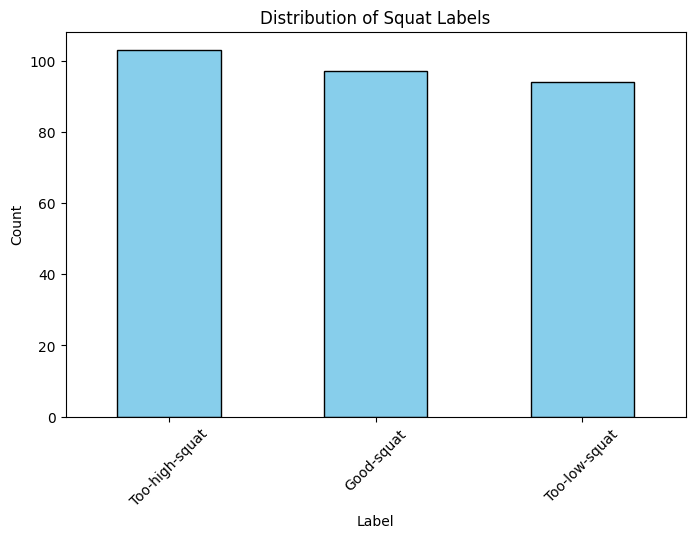

In [46]:
# 2. Distribution of Labels
label_counts = finally_squat['error-label'].value_counts()
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Squat Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

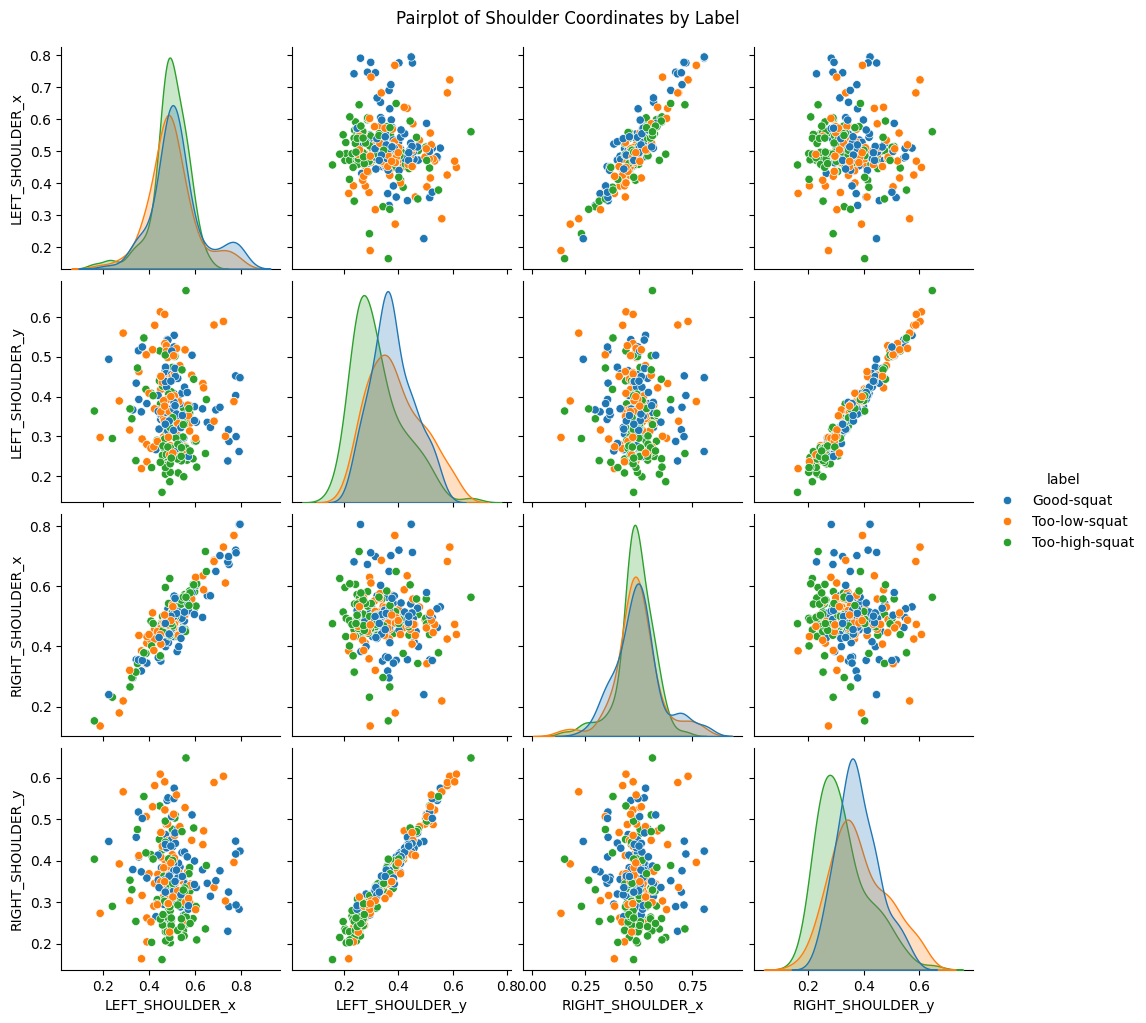

In [29]:
# 3. Pairplot for Coordinate Relationships (Sample Columns)
sample_coordinates = [
    'LEFT_SHOULDER_x', 'LEFT_SHOULDER_y', 'RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_y', 'label'
]
sns.pairplot(finally_squat[sample_coordinates], hue='label', diag_kind='kde', height=2.5)
plt.suptitle('Pairplot of Shoulder Coordinates by Label', y=1.02)
plt.show()

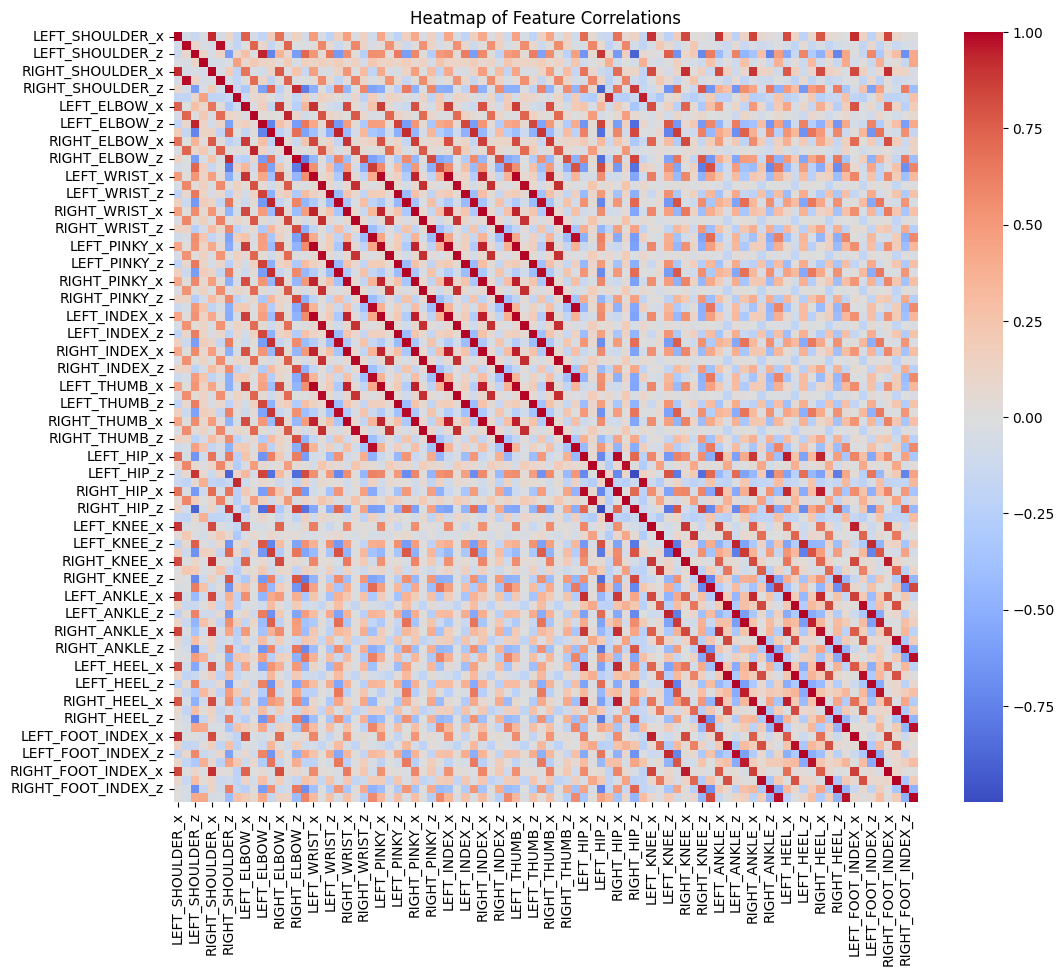

In [30]:
# 4. Heatmap of Correlations
numeric_data = finally_squat.drop(columns=['frame', 'label'])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Heatmap of Feature Correlations')
plt.show()